In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

REPO_PATH = 'C:/Users/soysa/Documents/Git/visual_encoding'
data_directory = f'C:/datasets/allen_vc/manifest_files'

import sys
sys.path.append(REPO_PATH)
from allen_vc.epoch_extraction_tools import *
from allen_vc.plts import plot_epochs

print('Packages Imported')

Packages Imported


In [5]:
# settings
PF = 50
KERNEL_SIZE = 1*PF

In [7]:
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()
sessions = sessions[sessions.get('session_type')=='functional_connectivity']
sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [8]:
session_id = 766640955
session = cache.get_session_data(session_id)
pupil_data = session.get_screen_gaze_data()
pupil_data.head()

C:\Users\soysa\Anaconda3\envs\Allen\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.16310,0.058795,0.011054,3.969006,-1.626442,14.739801,-6.189063
3.19620,0.058669,0.011164,4.001801,-1.664556,14.852316,-6.332932
3.21337,0.058594,0.011342,4.086463,-1.686111,15.149932,-6.414260
3.24650,0.058705,0.011354,4.085960,-1.687487,15.148002,-6.419451
3.27980,0.058736,0.011374,4.101932,-1.634886,15.210047,-6.220944


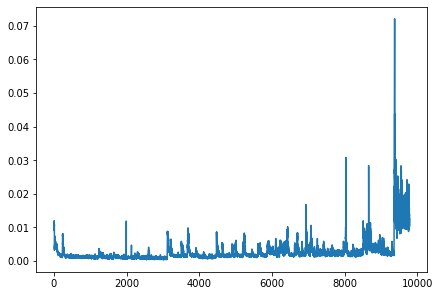

In [9]:
pupil_data = pupil_data[pupil_data['raw_pupil_area'].notna()]
values = pupil_data['raw_pupil_area']
time_points = pupil_data.index

#Create uniform set of data using interpolation
model = interpolate.interp1d(time_points, values)
time = np.arange(time_points[0], time_points[-1], 1/PF)
area = model(time)
plt.plot(time, area);

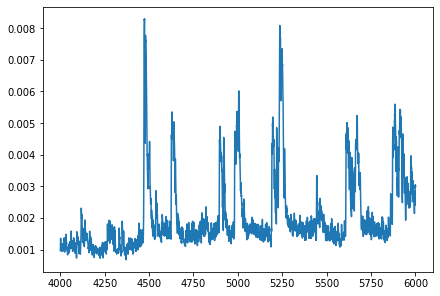

In [10]:
from scipy.ndimage import median_filter

stim_pupil_area = area[(time > 4000) & (time < 6000)] # approx time of spontaneous block
stim_time = time[(time > 4000) & (time < 6000)]
stim_pupil_filt = median_filter(stim_pupil_area, KERNEL_SIZE)
plt.plot(stim_time, stim_pupil_filt);

In [11]:
# settings for epoching (found based on experimentation in epoch_counts.ipynb)
ABOVE_THRESHOLD = 0.0000025
BELOW_THRESHOLD = -0.0000001
MIN_GAP = 0.05
ABOVE_MIN_DURATION = 0.5
BELOW_MIN_DURATION = 2

Identified 4912 epochs
Joined 2205 / 4912 epochs
Joined 3837 / 4913 epochs
Dropped 2617 / 2707 epochs
Dropped 641 / 1076 epochs
Identified 3548 epochs
Joined 612 / 3548 epochs
Joined 2004 / 3548 epochs
Dropped 2863 / 2936 epochs
Dropped 1470 / 1544 epochs
Found 90 Above Epochs and 74 Below Epochs



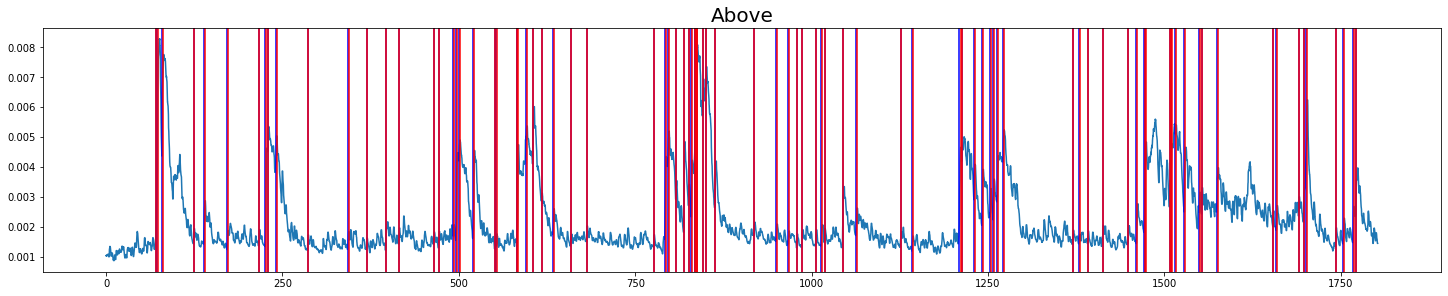

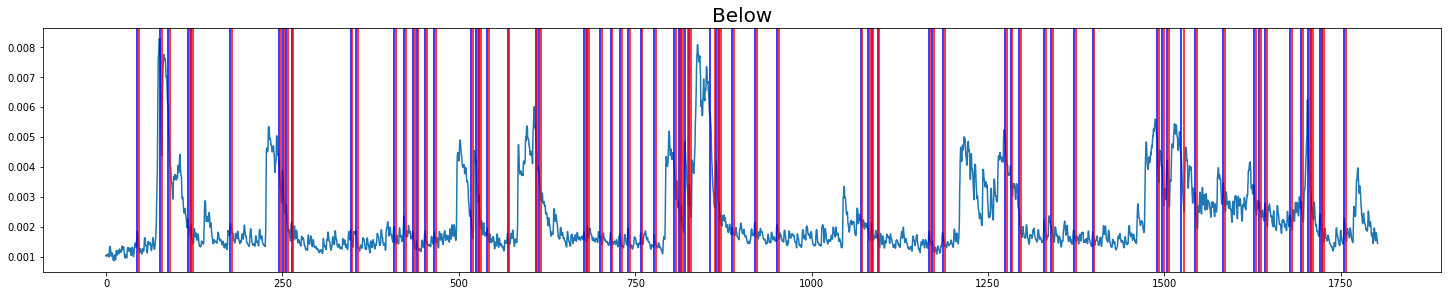

In [14]:
group = pd.read_pickle(f"G:/Shared drives/visual_encoding/data/behavior/pupil/spontaneous/pupil_area_{session_id}.pkl")
sig =  group.analogsignals[4]
area_deriv = np.diff(sig.magnitude.T[0])
above, _ = get_epoch_times(area_deriv, ABOVE_THRESHOLD, MIN_GAP, ABOVE_MIN_DURATION, PF)
_, below = get_epoch_times(area_deriv, BELOW_THRESHOLD, MIN_GAP, BELOW_MIN_DURATION, PF)

print(f'Found {len(above)} Above Epochs and {len(below)} Below Epochs\n')

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, above)
plt.title("Above")

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, below)
plt.title("Below");

In [16]:
# average length of above epochs (dilation)
np.mean(above[:,1] - above[:,0])

0.8295555555555593

In [17]:
# average length of below epochs (constriction)
np.mean(below[:,1] - below[:,0])

2.628648648648637

### Time-resolved FFT of LFP to extract parameters for shorter epochs

In [22]:
from allen_vc.allen_utils import find_probes_in_region, align_lfp

In [26]:
probe_id = find_probes_in_region(session, 'VISp')[0][0]
lfp = session.get_lfp(probe_id)

Downloading: 100%|██████████| 2.17G/2.17G [04:49<00:00, 7.49MB/s] 


In [30]:
chan_ids = session.channels[(session.channels.probe_id==probe_id) & \
                    (session.channels.ecephys_structure_acronym=='VISp')].index.values

In [31]:
lfp_spont = lfp.sel(time=slice(4000, 6000)).sel(channel=slice(np.min(chan_ids), np.max(chan_ids)))
lfp_spont

<xarray.DataArray 'LFP' (time: 2499999, channel: 22)>
array([[ 3.51195e-04,  4.02285e-04,  3.41640e-04, ...,  2.53500e-05,
         9.55500e-06, -1.07250e-05],
       [ 3.55875e-04,  3.98970e-04,  3.25845e-04, ...,  2.24250e-05,
         7.99500e-06, -1.15050e-05],
       [ 3.61140e-04,  3.97995e-04,  3.41250e-04, ...,  2.04750e-05,
         7.99500e-06, -1.44300e-05],
       ...,
       [-2.76900e-05, -3.62700e-05, -5.03100e-05, ...,  2.73000e-06,
         0.00000e+00,  6.24000e-06],
       [-4.48500e-05, -4.95300e-05, -5.81100e-05, ..., -3.51000e-06,
         2.73000e-06,  0.00000e+00],
       [-4.17300e-05, -4.27050e-05, -6.76650e-05, ..., -5.46000e-06,
         3.31500e-06,  1.75500e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 4e+03 4e+03 4e+03 4e+03 ... 6e+03 6e+03 6e+03 6e+03
  * channel  (channel) int64 850025318 850025326 ... 850025478 850025486

In [55]:
raw_lfp = lfp_spont.values

In [64]:
lfp_swapped = np.swapaxes(raw_lfp, 0 ,1)

In [56]:
# now we do time resolved fft!
import mne.time_frequency as mtf
from time import time as timer

In [65]:
wsize = 400 # multiple of 4
tstep = 100 # multiple of 2 and divisor of wsize

t_start = timer()
psd = mtf.stft(lfp_swapped, wsize, tstep, verbose=True)
print(timer() - t_start)

Number of frequencies: 201
Number of time steps: 25000
7.785742282867432


In [66]:
psd.shape # shape = (n_signals, wsize // 2 + 1, n_step)

(22, 201, 25000)

In [72]:
lfp_cropped = lfp_swapped[:,:10000]

In [73]:
t_start = timer()
psd = mtf.tfr_array_multitaper(np.array([lfp_cropped]),sfreq=1250,freqs=np.arange(1,30) , verbose=True)
print(timer() - t_start)

3.2597403526306152


In [74]:
psd.shape # (n_epochs, n_chans, n_tapers, n_freqs, n_times)

(1, 22, 3, 29, 10000)

In [75]:
t_start = timer()
psd = mtf.tfr_array_multitaper(np.array([lfp_cropped]),sfreq=1250,freqs=np.arange(1,30), output='power', verbose=True)
print(timer() - t_start)

3.4321835041046143


In [76]:
psd.shape # (n_epochs, n_chans, n_freqs, n_times)

(1, 22, 29, 10000)

In [77]:
import seaborn as sns

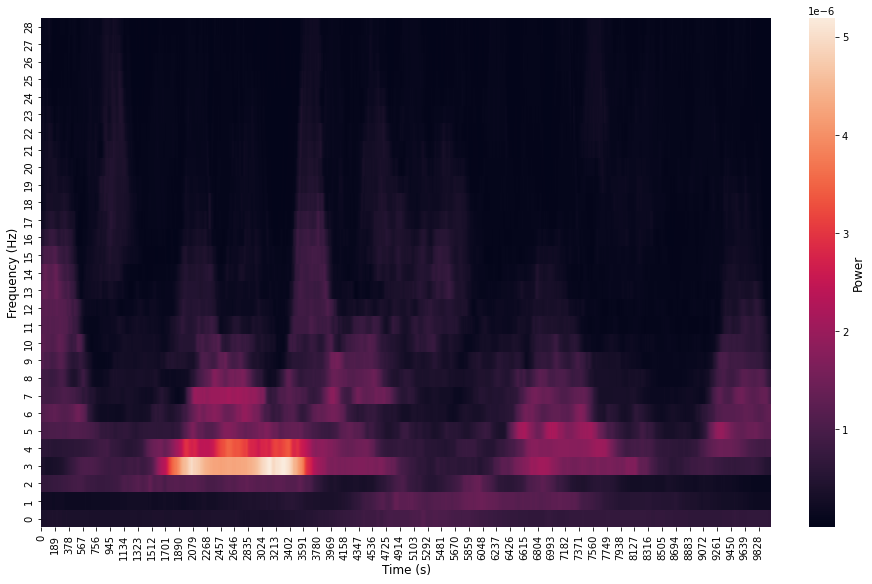

In [82]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(psd[0,0,:,:], cbar_kws={'label': 'Power'});
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');
ax.invert_yaxis()